In [1]:
!pip install inflect

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
mkl-random 1.0.1 requires cython, which is not installed.
tensorflow 1.10.0 has requirement numpy<=1.14.5,>=1.13.3, but you'll have numpy 1.15.2 which is incompatible.
tensorflow 1.10.0 has requirement setuptools<=39.1.0, but you'll have setuptools 40.2.0 which is incompatible.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!rm -r checkpoints

rm: checkpoints: No such file or directory


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from pprint import pprint
import inflect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# Data Load
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


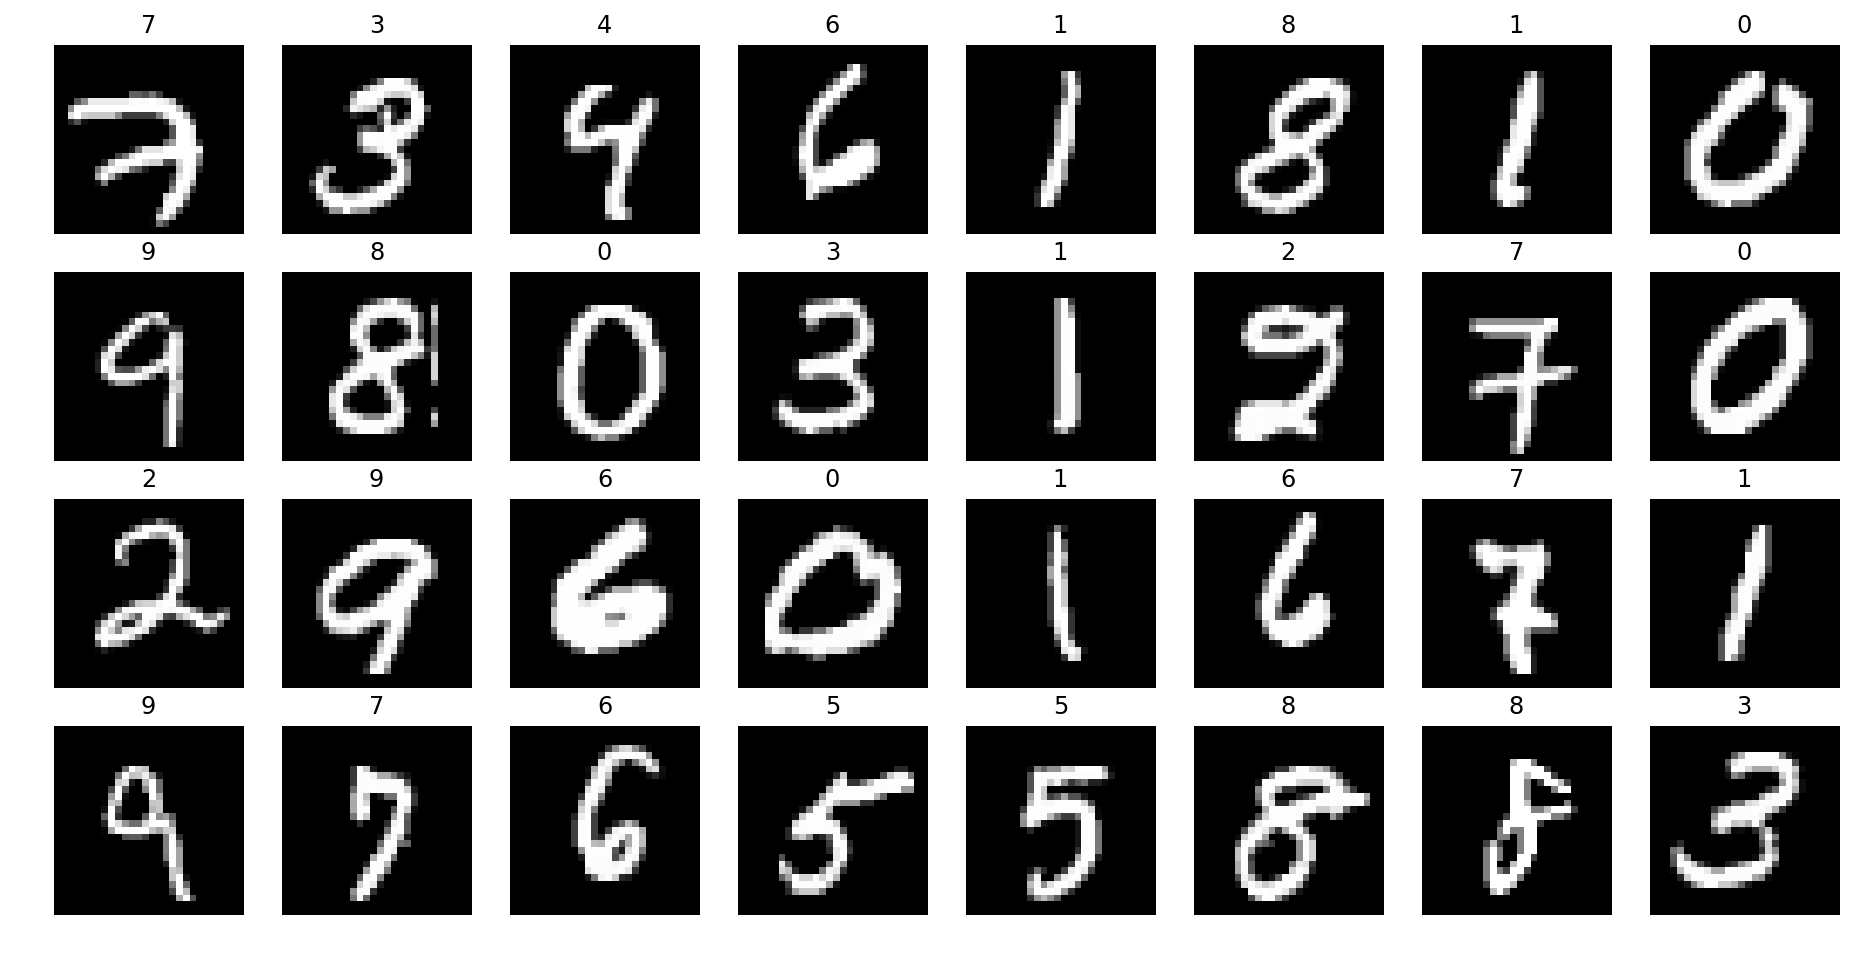

In [5]:
plt.figure(figsize=(16,8))
for k in range(32):
    img = mnist.train.images[k].reshape(28,28)
    label = np.argmax(mnist.train.labels[k])
    plt.subplot(4,8,1+k)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(label)
plt.show()

## Neural Network Model with various Hyper-Parameters

여러가지 Hyper-Parameter의 조합을 실험 후, 가장 좋은 결과를 찾아내는 프로젝트입니다.

- `dictionary` 형태로 `params_grid`에 추가 하며 수정하세요.

In [6]:
params_grid =[{'hidden_layer_info': [512, 256, 128], 
              'dropout_probs': [0.15, 0.15, 0.15], 
              'lr' : 0.0001,
              'batch_size' : 64, 
              'MaxEpochs' : 50,
              'optimizer' : tf.train.AdamOptimizer,
              'activation' : tf.nn.relu},
              {'hidden_layer_info': [512, 256, 128], 
              'dropout_probs': [0.15, 0.15, 0.15], 
              'lr' : 0.0001,
              'batch_size' : 128, 
              'MaxEpochs' : 50,
              'optimizer' : tf.train.GradientDescentOptimizer,
              'activation' : tf.nn.relu},
              {'hidden_layer_info': [30], 
              'dropout_probs': [0.0], 
              'lr' : 0.01,
              'batch_size' : 32, 
              'MaxEpochs' : 40,
              'optimizer' : tf.train.AdamOptimizer,
              'activation' : tf.nn.sigmoid},
             ]

### Neural Network + Dropout

- `prob = 0` : No dropout

In [7]:
def build_logit(x, params, training=True):
    activation_fn = params['activation']
    hidden_layer = x
    for hidden_nodes, prob in zip(params['hidden_layer_info'], params['dropout_probs']):
        hidden_layer = tf.layers.dense(hidden_layer, hidden_nodes, activation=activation_fn)
        hidden_layer = tf.layers.dropout(hidden_layer, rate=prob, training=training)
    logits = tf.layers.dense(hidden_layer, 10, activation=None)
    return logits

### loss 정의

In [8]:
def build_loss(y, logit, params):
    loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=logit)
    return loss

### Optimizer 적용하기

In [9]:
def build_optimizer(params):
    lr = params['lr']
    optimizer = params['optimizer']
    return optimizer(lr)

### Checkpoint 폴더 만들기

In [10]:
!mkdir checkpoints

### 모든 Hyper-Parameter 실험해보기

In [ ]:
import os
p = inflect.engine()
for param_id, params in enumerate(params_grid, 1):
    nth_string = p.ordinal(param_id)
    print("============={0} Hyper-Parameter==============".format(nth_string))
    pprint(params)
    print("============={0} Hyper-Parameter==============".format(nth_string))

    tf.reset_default_graph()
    
    x = tf.placeholder(tf.float32, [None, 784])
    y = tf.placeholder(tf.float32, [None, 10])
    isTraining = tf.placeholder(tf.bool)

    batch_size = params['batch_size']
    chosen_logits = build_logit(x, params, training=isTraining)
    loss = build_loss(y, chosen_logits, params)
    train = build_optimizer(params).minimize(loss)
    
    # saver
    saver = tf.train.Saver(max_to_keep=25)
    # For testing accuracy
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(chosen_logits,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    for epoch in range(params['MaxEpochs']):
        train_loss = 0
        for step in range(len(mnist.train.images) // batch_size + 1):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            batch_loss,_ = sess.run([loss, train], feed_dict={x:batch_xs, y:batch_ys, isTraining: True})
            train_loss += batch_loss * len(batch_xs)
            if step % 200 == 0:
                curr_acc = sess.run(accuracy, feed_dict={x:mnist.test.images, y:mnist.test.labels, isTraining: False})
                print(epoch, step, curr_acc)
                if not os.path.exists("./checkpoints/{0}".format(nth_string)):
                    os.mkdir("./checkpoints/{0}".format(nth_string))
                saver.save(sess, "./checkpoints/{0}/model_epoch{1}_step_{2}.ckpt".format(nth_string,epoch, step))
        curr_acc, test_loss = sess.run([accuracy, loss], feed_dict={x:mnist.test.images, y:mnist.test.labels, isTraining: False})
        train_loss /= len(mnist.train.images)
        print("====>", epoch, train_loss, test_loss, curr_acc)
        print("")
    print("")

=============1st Hyper-Parameter==============
{'MaxEpochs': 50,
 'activation': <function relu at 0x130d98ae8>,
 'batch_size': 64,
 'dropout_probs': [0.15, 0.15, 0.15],
 'hidden_layer_info': [512, 256, 128],
 'lr': 0.0001,
 'optimizer': <class 'tensorflow.python.training.adam.AdamOptimizer'>}
=============1st Hyper-Parameter==============
0 0 0.1197
0 200 0.8762
0 400 0.9107
0 600 0.9244
0 800 0.9332
====> 0 0.5964041967218573 0.22125956 0.9344

1 0 0.9347
1 200 0.9408
1 400 0.9473
1 600 0.9504
1 800 0.953
====> 1 0.23606509103775025 0.15366155 0.9533

2 0 0.9529
2 200 0.9559
2 400 0.958
2 600 0.9603
2 800 0.9602
====> 2 0.17022563687237827 0.12261045 0.9622

3 0 0.9625
3 200 0.9633
3 400 0.966
3 600 0.9654
3 800 0.9682
====> 3 0.13355719624215906 0.10108778 0.9683

4 0 0.9685
4 200 0.9698
4 400 0.9703
4 600 0.9711
4 800 0.9708
====> 4 0.11081016268079931 0.08958368 0.9725

5 0 0.9728
5 200 0.9717
5 400 0.9723
5 600 0.973
5 800 0.9741
====> 5 0.09189483412666755 0.08235714 0.9746

6 0 

21 200 0.6577
21 400 0.6625
====> 21 1.9367011324795809 1.8550664 0.6632

22 0 0.6632
22 200 0.6671
22 400 0.672
====> 22 1.9151507695978338 1.8295492 0.6732

23 0 0.6732
23 200 0.6768
23 400 0.681
====> 23 1.8929908782958984 1.8034732 0.6813

24 0 0.6814
24 200 0.6855
24 400 0.6888
====> 24 1.8678149264248936 1.7767184 0.6892

25 0 0.6892
25 200 0.6927
25 400 0.6957
====> 25 1.8450500821200284 1.7495034 0.6961

26 0 0.696
26 200 0.6997
26 400 0.7031
====> 26 1.8223832394686612 1.7218404 0.7035

27 0 0.7035
27 200 0.7073
27 400 0.7106
====> 27 1.797066319136186 1.6937164 0.711

28 0 0.7112
28 200 0.7143
28 400 0.7168
====> 28 1.771553369140625 1.6651183 0.7167

29 0 0.7166
29 200 0.7179
29 400 0.7198
====> 29 1.7468369426380503 1.6361775 0.7204

30 0 0.7205
30 200 0.7232
30 400 0.7254
====> 30 1.7218754655317827 1.6069348 0.7257

31 0 0.7257
31 200 0.7278
31 400 0.7302
====> 31 1.6942347886518998 1.5774884 0.7303

32 0 0.7302
32 200 0.7322
32 400 0.7339
====> 32 1.670210286365856 1.547

In [12]:
def restore_and_test(restore_id, epoch, step, params_grid):
    tf.reset_default_graph()
    param_id, params = restore_id+1, params_grid[restore_id]
    nth_string = p.ordinal(param_id)
    print("============={0} Hyper-Parameter==============".format(nth_string))
    pprint(params)
    print("============={0} Hyper-Parameter==============".format(nth_string))

    checkpoint_filepath = "./checkpoints/{0}/model_epoch{1}_step_{2}.ckpt".format(nth_string,epoch, step)

    x = tf.placeholder(tf.float32, [None, 784])
    y = tf.placeholder(tf.float32, [None, 10])

    chosen_logits = build_logit(x, params, training=False)
    loss = build_loss(y, chosen_logits, params)

    # saver
    saver = tf.train.Saver(max_to_keep=25)

    # For testing accuracy
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(chosen_logits,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    sess = tf.Session()
    saver.restore(sess, checkpoint_filepath)
    curr_acc, test_loss = sess.run([accuracy, loss], feed_dict={x:mnist.test.images, y:mnist.test.labels})
    print("")
    print("")
    print("Accuracy : {0:4.3f}%".format(curr_acc * 100))

## 최종 모델을 선택하세요.

Checkpoint 파일이 존재하는지 한번 더 확인해보세요.

In [14]:
restore_id, epoch, step = 0, 39, 0
restore_and_test(restore_id, epoch, step, params_grid)

=============1st Hyper-Parameter==============
{'MaxEpochs': 40,
 'activation': <function relu at 0x12fae4ae8>,
 'batch_size': 64,
 'dropout_probs': [0.15, 0.15, 0.15],
 'hidden_layer_info': [512, 256, 128],
 'lr': 0.001,
 'optimizer': <class 'tensorflow.python.training.adam.AdamOptimizer'>}
=============1st Hyper-Parameter==============
INFO:tensorflow:Restoring parameters from ./checkpoints/1st/model_epoch39_step_0.ckpt


Accuracy : 98.520%
